In [1]:
# Import libraries
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import numpy as np
import seaborn as sns
from itertools import product
import matplotlib.pyplot as plt
import sklearn.metrics as met
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [2]:
# Function to evaluate model
def evaluate_model(y_test, y_pred):
    """ Displays accuracy, classification report and cofusion matrix """
    accuracy = met.accuracy_score(y_test, y_pred)
    print('Test Accuracy: {:.4f}%'.format(accuracy * 100))
    print('\nClassification Report:')
    print(met.classification_report(y_test, y_pred))

    # Plot the confusion matrix
    conf_matrix = met.confusion_matrix(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [3]:
# Function to plot ROC curve
def plot_roc_curve(true_y, y_pred):
    """ Plots the roc curve based of the probabilities """
    fpr, tpr, thresholds = met.roc_curve(true_y, y_pred)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

# GTCC-MFCC

## Data Preprocessing

In [4]:
# Load MFCC and GTCC features from CSV files
col_names = ['LogEnergy'] + [f'GTCC{i}' for i in range(13)] + ['LogEnergy_delta'] + [f'GTCC{i}_delta' for i in range(13)] + ['LogEnergy_delta-delta'] + [f'GTCC{i}_delta-delta' for i in range(13)] + [f'MFCC{i}' for i in range(13)] + [f'MFCC{i}_delta' for i in range(13)] + [f'MFCC{i}_delta-delta' for i in range(13)] + ['label']

train = pd.read_csv("./extracted_features/GTCC-MFCC_train.csv", header=None, names=col_names)
val = pd.read_csv("./extracted_features/GTCC-MFCC_val.csv", header=None, names=col_names)
test = pd.read_csv("./extracted_features/GTCC-MFCC_test.csv", header=None, names=col_names)

In [5]:
col_names = ['LogEnergy'] + [f'GTCC{i}' for i in range(13)] + ['LogEnergy_delta'] + [f'GTCC{i}_delta' for i in range(13)] + ['LogEnergy_delta-delta'] + [f'GTCC{i}_delta-delta' for i in range(13)] + [f'MFCC{i}' for i in range(13)] + [f'MFCC{i}_delta' for i in range(13)] + [f'MFCC{i}_delta-delta' for i in range(13)]

# Normalization using StandardScaler
X_train = train.drop('label', axis=1)
y_train = train['label']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Concatenate the scaled features with the labels
train_scaled = pd.concat([pd.DataFrame(X_train, columns=col_names), y_train], axis=1)

In [6]:
# Normalized data
train_scaled.head()

,LogEnergy,GTCC0,GTCC1,GTCC2,GTCC3,GTCC4,GTCC5,GTCC6,GTCC7,GTCC8,...,MFCC4_delta-delta,MFCC5_delta-delta,MFCC6_delta-delta,MFCC7_delta-delta,MFCC8_delta-delta,MFCC9_delta-delta,MFCC10_delta-delta,MFCC11_delta-delta,MFCC12_delta-delta,label
0,-0.128510,0.073872,-0.236758,0.851631,0.513468,0.861742,0.227095,0.762275,1.002205,0.122225,...,-0.026832,0.790067,0.110165,-0.595030,-1.088868,-0.601788,-1.789699,0.316753,-0.132822,0
1,-0.029417,0.033635,0.518809,0.775044,-0.227556,-0.899901,-1.305552,1.331716,0.514825,-1.485395,...,-0.067333,0.132257,-0.051792,-0.305196,-0.466887,0.431240,0.404350,0.061240,-0.208908,0
2,0.379600,0.248687,-0.508618,-0.195609,-0.302293,-0.905960,0.002100,0.147866,-0.938601,-0.878436,...,-0.371035,0.130630,0.074267,-0.054581,0.134074,0.216466,-0.218511,0.737281,-0.340147,0
3,-0.198182,-0.056271,-0.149156,1.077413,-0.129536,0.555747,1.067700,0.010510,-0.880083,0.239690,...,0.058219,0.368789,0.119126,-0.124527,-0.087493,-0.368293,-0.300123,0.092421,0.070479,0
4,0.316611,0.183990,1.104448,0.182811,-0.683060,0.694967,-1.147925,-0.482096,-1.926380,-1.261906,...,-0.805542,-0.897721,-1.134657,-1.145954,-0.142735,-1.032443,-1.285619,-0.370139,-0.810454,0


In [7]:
# Validation data
X_val = val.drop('label', axis=1)  # Features
y_val = val['label']   # Labels

# Normalize validation data
X_val = scaler.transform(X_val)
val_scaled = pd.concat([pd.DataFrame(X_val), y_val], axis=1)

In [8]:
# Test data
X_test = test.drop('label', axis=1)  # Features
y_test = test['label']   # Labels

# Normalize validation data
X_test = scaler.transform(X_test)
test_scaled = pd.concat([pd.DataFrame(X_test), y_test], axis=1)

In [9]:
# SMOTE data augmentation
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# Apply SMOTE
smote = SMOTE(random_state=42, sampling_strategy='minority')
X_train, y_train = smote.fit_resample(X_train, y_train)

# Concatenate the resampled features and labels
train_resampled = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train, columns=['label'])], axis=1)

print('After OverSampling, the shape of X_train: {}'.format(X_train.shape))
print('After OverSampling, the shape of y_train: {} \n'.format(y_train.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train == 0)))

Before OverSampling, counts of label '1': 2580
Before OverSampling, counts of label '0': 22800 

After OverSampling, the shape of X_train: (45600, 81)
After OverSampling, the shape of y_train: (45600,) 

After OverSampling, counts of label '1': 22800
After OverSampling, counts of label '0': 22800


## Modeling

Test Accuracy: 88.9524%

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94     63882
           1       0.44      0.28      0.34      7355

    accuracy                           0.89     71237
   macro avg       0.68      0.62      0.64     71237
weighted avg       0.87      0.89      0.88     71237



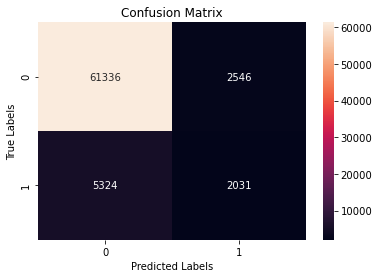

AUC score: 0.618141974503424


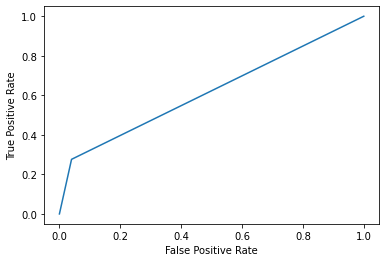

In [10]:
# Baseline without SMOTE using XGBoost and GTCC-MFCC features
xgb = XGBClassifier()
xgb.fit(train_scaled.drop('label', axis=1), train_scaled['label'])

# Prediction
y_pred = xgb.predict(X_test)

# Model evaluation
evaluate_model(y_test, y_pred)

# Plot ROC curve
plot_roc_curve(y_test, y_pred)
print(f'AUC score: {met.roc_auc_score(y_test, y_pred)}')

### 1.0 XGBoost

#### Hyperparameter Tuning

In [11]:
# Define hyperparameter values
n_estimators = [100, 200, 300, 400, 600, 800, 1000]
max_depth = [None, 3, 6, 9, 12, 15]
min_child_weight = [1, 3, 5]
gamma = [0.1, 0.5, 1] 
subsample = [0.8]
colsample_bytree = [0.8]

# Create a list of all combinations of hyperparameters
hyperparameter_combinations = list(product(n_estimators, max_depth, min_child_weight, gamma, subsample, colsample_bytree))

# Total number of combinations
total_combinations = len(hyperparameter_combinations)

best_score = 0
best_params = {}

# Loop through all combinations
for i, (n_estimators, max_depth, min_child_weight, gamma, subsample, colsample_bytree) in enumerate(hyperparameter_combinations, 1):
    print(f"Progress: {i}/{total_combinations}")
    print(f"n_estimators: {n_estimators}, max_depth: {max_depth}, min_child_weight: {min_child_weight}, gamma: {gamma}, subsample: {subsample}, colsample_bytree: {colsample_bytree}")
    
    # Create RandomForestClassifier with current hyperparameters
    xgb = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        objective='binary:logistic',
        seed=42
    )

    # Fit on training data
    xgb.fit(X_train, y_train)

    # Predict on validation set
    y_val_pred = xgb.predict(X_val)

    # Evaluate accuracy on validation set
    f1 = met.f1_score(y_val, y_val_pred, average='macro')
    print("Current score: ", f1)

    # Check if current model is the best
    if f1 > best_score:
        best_score = f1
        best_params = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'min_child_weight': min_child_weight,
            'gamma': gamma,
            'subsample': subsample,
            'colsample_bytree': colsample_bytree
        }

    # Add a new line for better readability
    print("\n")

# Display the best parameters found 
print("Best parameters:", best_params)
print("Best score on Validation Set:", best_score)

Progress: 1/378
n_estimators: 100, max_depth: None, min_child_weight: 1, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6736767187844643


Progress: 2/378
n_estimators: 100, max_depth: None, min_child_weight: 1, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6698753122189197


Progress: 3/378
n_estimators: 100, max_depth: None, min_child_weight: 1, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6726009315017827


Progress: 4/378
n_estimators: 100, max_depth: None, min_child_weight: 3, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6724585698449749


Progress: 5/378
n_estimators: 100, max_depth: None, min_child_weight: 3, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6715278258423951


Progress: 6/378
n_estimators: 100, max_depth: None, min_child_weight: 3, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6774985540682854


Progress: 7/378
n_estimators: 100, max_depth

Current score:  0.6652569222607958


Progress: 54/378
n_estimators: 100, max_depth: 15, min_child_weight: 5, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6728849031546393


Progress: 55/378
n_estimators: 200, max_depth: None, min_child_weight: 1, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.661450167620296


Progress: 56/378
n_estimators: 200, max_depth: None, min_child_weight: 1, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6649239327533235


Progress: 57/378
n_estimators: 200, max_depth: None, min_child_weight: 1, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6595360928822404


Progress: 58/378
n_estimators: 200, max_depth: None, min_child_weight: 3, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6646604500489581


Progress: 59/378
n_estimators: 200, max_depth: None, min_child_weight: 3, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.664795267810891


Progr

Current score:  0.6744923775127738


Progress: 106/378
n_estimators: 200, max_depth: 15, min_child_weight: 5, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6631747990945664


Progress: 107/378
n_estimators: 200, max_depth: 15, min_child_weight: 5, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6643322049590717


Progress: 108/378
n_estimators: 200, max_depth: 15, min_child_weight: 5, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6737208645632318


Progress: 109/378
n_estimators: 300, max_depth: None, min_child_weight: 1, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6619914206576096


Progress: 110/378
n_estimators: 300, max_depth: None, min_child_weight: 1, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6646558748171636


Progress: 111/378
n_estimators: 300, max_depth: None, min_child_weight: 1, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6589831207456593


P

Current score:  0.6621656876841198


Progress: 158/378
n_estimators: 300, max_depth: 15, min_child_weight: 3, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.666495353812525


Progress: 159/378
n_estimators: 300, max_depth: 15, min_child_weight: 3, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6745904919742405


Progress: 160/378
n_estimators: 300, max_depth: 15, min_child_weight: 5, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6650946388530902


Progress: 161/378
n_estimators: 300, max_depth: 15, min_child_weight: 5, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6645314725331262


Progress: 162/378
n_estimators: 300, max_depth: 15, min_child_weight: 5, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6742173475409747


Progress: 163/378
n_estimators: 400, max_depth: None, min_child_weight: 1, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6594733864559935


Progre

Current score:  0.6757336776220858


Progress: 210/378
n_estimators: 400, max_depth: 15, min_child_weight: 1, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6714099464114058


Progress: 211/378
n_estimators: 400, max_depth: 15, min_child_weight: 3, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6625426673755843


Progress: 212/378
n_estimators: 400, max_depth: 15, min_child_weight: 3, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6669767685777974


Progress: 213/378
n_estimators: 400, max_depth: 15, min_child_weight: 3, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6745880452612352


Progress: 214/378
n_estimators: 400, max_depth: 15, min_child_weight: 5, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6617692939809537


Progress: 215/378
n_estimators: 400, max_depth: 15, min_child_weight: 5, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6639148001608474


Progres

Current score:  0.6732325926263989


Progress: 262/378
n_estimators: 600, max_depth: 15, min_child_weight: 1, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6719322297246714


Progress: 263/378
n_estimators: 600, max_depth: 15, min_child_weight: 1, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6751471361131334


Progress: 264/378
n_estimators: 600, max_depth: 15, min_child_weight: 1, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6734950564074219


Progress: 265/378
n_estimators: 600, max_depth: 15, min_child_weight: 3, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6622643520497085


Progress: 266/378
n_estimators: 600, max_depth: 15, min_child_weight: 3, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6656114658478725


Progress: 267/378
n_estimators: 600, max_depth: 15, min_child_weight: 3, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6749061426524251


Progres

Current score:  0.6704894868760025


Progress: 314/378
n_estimators: 800, max_depth: 12, min_child_weight: 5, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6673827053625531


Progress: 315/378
n_estimators: 800, max_depth: 12, min_child_weight: 5, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6724329215298778


Progress: 316/378
n_estimators: 800, max_depth: 15, min_child_weight: 1, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6706290855703577


Progress: 317/378
n_estimators: 800, max_depth: 15, min_child_weight: 1, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6752290939513967


Progress: 318/378
n_estimators: 800, max_depth: 15, min_child_weight: 1, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6733016996043307


Progress: 319/378
n_estimators: 800, max_depth: 15, min_child_weight: 3, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6621656876841198


Progres

Current score:  0.675044206947532


Progress: 366/378
n_estimators: 1000, max_depth: 12, min_child_weight: 3, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6767009561308609


Progress: 367/378
n_estimators: 1000, max_depth: 12, min_child_weight: 5, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6712884371273763


Progress: 368/378
n_estimators: 1000, max_depth: 12, min_child_weight: 5, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6670168895768732


Progress: 369/378
n_estimators: 1000, max_depth: 12, min_child_weight: 5, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6719518436864271


Progress: 370/378
n_estimators: 1000, max_depth: 15, min_child_weight: 1, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.671419449571301


Progress: 371/378
n_estimators: 1000, max_depth: 15, min_child_weight: 1, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6755914630659496


Pro

####Model

In [12]:
# Model with best params
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    min_child_weight=1,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    seed=42
)

# Fit model
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Test Accuracy: 79.5163%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.80      0.88     63882
           1       0.30      0.74      0.43      7355

    accuracy                           0.80     71237
   macro avg       0.63      0.77      0.65     71237
weighted avg       0.90      0.80      0.83     71237



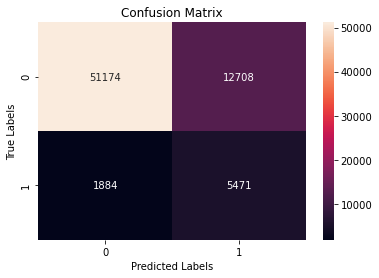

In [13]:
# Make predictions on the test set
y_pred_xgb = xgb.predict(X_test)

# Model evaluation
evaluate_model(y_test, y_pred_xgb)

AUC score: 0.7724592233926544


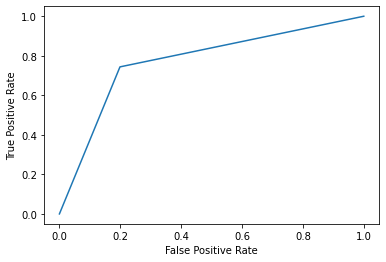

In [14]:
# Plot ROC curve
plot_roc_curve(y_test, y_pred_xgb)
print(f'AUC score: {met.roc_auc_score(y_test, y_pred_xgb)}')

### 2.0 Random Forest

#### Hyperparameter Tuning

In [15]:
# Define hyperparameter values
n_estimators = [100, 200, 300, 400, 600, 800, 1000]
max_depths = [None, 10, 20, 30]
min_samples_splits = [2, 5, 10]
min_samples_leafs = [1, 2, 4]

# Create a list of all combinations of hyperparameters
hyperparameter_combinations = list(product(n_estimators, max_depths, min_samples_splits, min_samples_leafs))

# Total number of combinations
total_combinations = len(hyperparameter_combinations)

best_score = 0
best_params = {}

# Loop through all combinations
for i, (n_estimators, max_depth, min_samples_split, min_samples_leaf) in enumerate(hyperparameter_combinations, 1):
    print(f"Progress: {i}/{total_combinations}")
    print(f"n_estimators: {n_estimators}, max_depth: {max_depth}, min_samples_split: {min_samples_split}, min_samples_leaf: {min_samples_leaf}")
    
    # Create RandomForestClassifier with current hyperparameters
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Fit on training data
    rf.fit(X_train, y_train)

    # Predict on validation set
    y_val_pred = rf.predict(X_val)

    # Evaluate accuracy on validation set
    f1 = met.f1_score(y_val, y_val_pred, average='macro')
    print("Current score: ", f1)

    # Check if current model is the best
    if f1 > best_score:
        best_score = f1
        best_params = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf
        }

    # Add a new line for better readability
    print("\n")

# Display the best parameters found 
print("Best parameters:", best_params)
print("Best score on Validation Set:", best_score)

Progress: 1/252
n_estimators: 100, max_depth: None, min_samples_split: 2, min_samples_leaf: 1
Current score:  0.6788992847632279


Progress: 2/252
n_estimators: 100, max_depth: None, min_samples_split: 2, min_samples_leaf: 2
Current score:  0.699668123433455


Progress: 3/252
n_estimators: 100, max_depth: None, min_samples_split: 2, min_samples_leaf: 4
Current score:  0.7079653859403928


Progress: 4/252
n_estimators: 100, max_depth: None, min_samples_split: 5, min_samples_leaf: 1
Current score:  0.6832577786988538


Progress: 5/252
n_estimators: 100, max_depth: None, min_samples_split: 5, min_samples_leaf: 2
Current score:  0.6940411943029965


Progress: 6/252
n_estimators: 100, max_depth: None, min_samples_split: 5, min_samples_leaf: 4
Current score:  0.7079653859403928


Progress: 7/252
n_estimators: 100, max_depth: None, min_samples_split: 10, min_samples_leaf: 1
Current score:  0.685344388694263


Progress: 8/252
n_estimators: 100, max_depth: None, min_samples_split: 10, min_sampl

Current score:  0.7176250573140118


Progress: 64/252
n_estimators: 200, max_depth: 30, min_samples_split: 2, min_samples_leaf: 1
Current score:  0.6974995518108914


Progress: 65/252
n_estimators: 200, max_depth: 30, min_samples_split: 2, min_samples_leaf: 2
Current score:  0.703533577170503


Progress: 66/252
n_estimators: 200, max_depth: 30, min_samples_split: 2, min_samples_leaf: 4
Current score:  0.71164446430641


Progress: 67/252
n_estimators: 200, max_depth: 30, min_samples_split: 5, min_samples_leaf: 1
Current score:  0.6967908298595934


Progress: 68/252
n_estimators: 200, max_depth: 30, min_samples_split: 5, min_samples_leaf: 2
Current score:  0.7054738717393073


Progress: 69/252
n_estimators: 200, max_depth: 30, min_samples_split: 5, min_samples_leaf: 4
Current score:  0.71164446430641


Progress: 70/252
n_estimators: 200, max_depth: 30, min_samples_split: 10, min_samples_leaf: 1
Current score:  0.6984965539890617


Progress: 71/252
n_estimators: 200, max_depth: 30, min_sa

Current score:  0.7052929998825289


Progress: 127/252
n_estimators: 400, max_depth: 20, min_samples_split: 2, min_samples_leaf: 1
Current score:  0.7132979865746256


Progress: 128/252
n_estimators: 400, max_depth: 20, min_samples_split: 2, min_samples_leaf: 2
Current score:  0.7139685831052816


Progress: 129/252
n_estimators: 400, max_depth: 20, min_samples_split: 2, min_samples_leaf: 4
Current score:  0.7156737910202349


Progress: 130/252
n_estimators: 400, max_depth: 20, min_samples_split: 5, min_samples_leaf: 1
Current score:  0.7122838430843048


Progress: 131/252
n_estimators: 400, max_depth: 20, min_samples_split: 5, min_samples_leaf: 2
Current score:  0.7140472894519216


Progress: 132/252
n_estimators: 400, max_depth: 20, min_samples_split: 5, min_samples_leaf: 4
Current score:  0.7156737910202349


Progress: 133/252
n_estimators: 400, max_depth: 20, min_samples_split: 10, min_samples_leaf: 1
Current score:  0.7147187289723551


Progress: 134/252
n_estimators: 400, max_dept

Current score:  0.7116502215439848


Progress: 190/252
n_estimators: 800, max_depth: 10, min_samples_split: 2, min_samples_leaf: 1
Current score:  0.7057564815153612


Progress: 191/252
n_estimators: 800, max_depth: 10, min_samples_split: 2, min_samples_leaf: 2
Current score:  0.7065401628753634


Progress: 192/252
n_estimators: 800, max_depth: 10, min_samples_split: 2, min_samples_leaf: 4
Current score:  0.7049871260851552


Progress: 193/252
n_estimators: 800, max_depth: 10, min_samples_split: 5, min_samples_leaf: 1
Current score:  0.7050554051425635


Progress: 194/252
n_estimators: 800, max_depth: 10, min_samples_split: 5, min_samples_leaf: 2
Current score:  0.7061098698590514


Progress: 195/252
n_estimators: 800, max_depth: 10, min_samples_split: 5, min_samples_leaf: 4
Current score:  0.7049871260851552


Progress: 196/252
n_estimators: 800, max_depth: 10, min_samples_split: 10, min_samples_leaf: 1
Current score:  0.7044386700620957


Progress: 197/252
n_estimators: 800, max_dept

Current score:  0.7138517399798726


Best parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 4}
Best score on Validation Set: 0.7183798330151575


#### Model

In [16]:
# Model with best params
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42
)

# Fit training set
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=10,
                       random_state=42)

Test Accuracy: 81.9743%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.83      0.89     63882
           1       0.33      0.73      0.46      7355

    accuracy                           0.82     71237
   macro avg       0.65      0.78      0.67     71237
weighted avg       0.90      0.82      0.85     71237



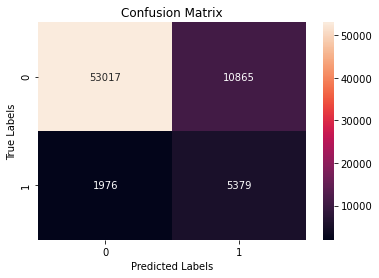

In [17]:
# Make predictions on the test set
y_pred_rf_gtcc_mfcc = rf.predict(X_test)

# Model evaluation
evaluate_model(y_test, y_pred_rf_gtcc_mfcc)

AUC score: 0.7806300082381241


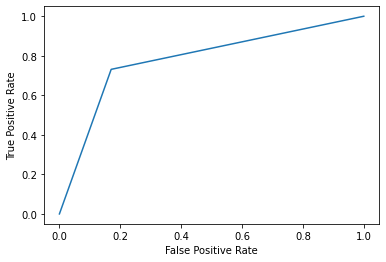

In [18]:
plot_roc_curve(y_test, y_pred_rf_gtcc_mfcc)
print(f'AUC score: {met.roc_auc_score(y_test, y_pred_rf_gtcc_mfcc)}')

## SVM

#### Hyperparameter Tuning

In [19]:
# Define hyperparameter values
kernels = ['poly', 'rbf']
Cs = [0.01, 0.1, 1, 10, 100]
gammas = ['scale', 'auto']

# Create a list of all combinations of hyperparameters
hyperparameter_combinations = list(product(kernels, Cs, gammas))

# Total number of combinations
total_combinations = len(hyperparameter_combinations)

best_score = 0
best_params = {}

# Loop through all combinations
for i, (kernel, C, gamma) in enumerate(hyperparameter_combinations, 1):
    print(f"Progress: {i}/{total_combinations}")
    print(f"kernel: {kernel}, C: {C}, gamma: {gamma}")
    
    # Create RandomForestClassifier with current hyperparameters
    svm = SVC(
        kernel=kernel,
        C=C,
        gamma=gamma
    )

    # Fit on training data
    svm.fit(X_train, y_train)

    # Predict on validation set
    y_val_pred = svm.predict(X_val)

    # Evaluate accuracy on validation set
    f1 = met.f1_score(y_val, y_val_pred, average='macro')
    print("Current score: ", f1)

    # Check if current model is the best
    if f1 > best_score:
        best_score = f1
        best_params = {
            'kernel': kernel,
            'C': C,
            'gamma': gamma
        }

    # Add a new line for better readability
    print("\n")

# Display the best parameters found 
print("Best parameters:", best_params)
print("Best score on Validation Set:", best_score)

Progress: 1/20
kernel: poly, C: 0.01, gamma: scale
Current score:  0.4097188535772657


Progress: 2/20
kernel: poly, C: 0.01, gamma: auto
Current score:  0.30098538540121456


Progress: 3/20
kernel: poly, C: 0.1, gamma: scale
Current score:  0.6186146239677244


Progress: 4/20
kernel: poly, C: 0.1, gamma: auto
Current score:  0.5830022107565908


Progress: 5/20
kernel: poly, C: 1, gamma: scale
Current score:  0.6603665274845302


Progress: 6/20
kernel: poly, C: 1, gamma: auto
Current score:  0.6540391777661957


Progress: 7/20
kernel: poly, C: 10, gamma: scale
Current score:  0.637593631427159


Progress: 8/20
kernel: poly, C: 10, gamma: auto
Current score:  0.6414359491534802


Progress: 9/20
kernel: poly, C: 100, gamma: scale
Current score:  0.6132085951236528


Progress: 10/20
kernel: poly, C: 100, gamma: auto
Current score:  0.6181982057843485


Progress: 11/20
kernel: rbf, C: 0.01, gamma: scale
Current score:  0.6481476311437049


Progress: 12/20
kernel: rbf, C: 0.01, gamma: auto


#### Model

In [20]:
# Model with best params
svm = SVC(
    kernel='rbf',
    C=1,
    gamma='auto',
)

# Fit training dataset
svm.fit(X_train, y_train)

SVC(C=1, gamma='auto')

Test Accuracy: 79.3829%

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.81      0.88     63882
           1       0.28      0.64      0.39      7355

    accuracy                           0.79     71237
   macro avg       0.62      0.73      0.63     71237
weighted avg       0.88      0.79      0.83     71237



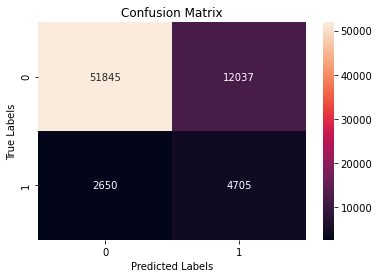

In [21]:
# Prediction
y_pred_svm = svm.predict(X_test)

# Model evaluation
evaluate_model(y_test, y_pred_svm)

AUC score: 0.7256376745865842


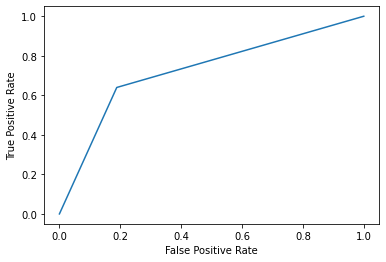

In [22]:
plot_roc_curve(y_test, y_pred_svm)
print(f'AUC score: {met.roc_auc_score(y_test, y_pred_svm)}')

## KNN

#### Hyperparameter Tuning

In [23]:
# Define hyperparameter values
n_neighbors = np.arange(2, 20, 1)
weights = ['uniform', 'distance']
p = [1, 2]

# Create a list of all combinations of hyperparameters
hyperparameter_combinations = list(product(n_neighbors, weights, p))

# Total number of combinations
total_combinations = len(hyperparameter_combinations)

best_score = 0
best_params = {}

# Loop through all combinations
for i, (n_neighbors, weights, p) in enumerate(hyperparameter_combinations, 1):
    print(f"Progress: {i}/{total_combinations}")
    print(f"n_neighbors: {n_neighbors}, weights: {weights}, p: {p}")
    
    # Create RandomForestClassifier with current hyperparameters
    knn = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        p=p
    )

    # Fit on training data
    knn.fit(X_train, y_train)

    # Predict on validation set
    y_val_pred = knn.predict(X_val)

    # Evaluate accuracy on validation set
    f1 = met.f1_score(y_val, y_val_pred, average='macro')
    print("Current score: ", f1)

    # Check if current model is the best
    if f1 > best_score:
        best_score = f1
        best_params = {
            'n_neighbors': n_neighbors,
            'weights': weights,
            'p': p
        }

    # Add a new line for better readability
    print("\n")

# Display the best parameters found 
print("Best parameters:", best_params)
print("Best score on Validation Set:", best_score)

Progress: 1/72
n_neighbors: 2, weights: uniform, p: 1
Current score:  0.6150853080223164


Progress: 2/72
n_neighbors: 2, weights: uniform, p: 2
Current score:  0.5964903478088884


Progress: 3/72
n_neighbors: 2, weights: distance, p: 1
Current score:  0.62359713763337


Progress: 4/72
n_neighbors: 2, weights: distance, p: 2
Current score:  0.5987834070434502


Progress: 5/72
n_neighbors: 3, weights: uniform, p: 1
Current score:  0.6254700055101592


Progress: 6/72
n_neighbors: 3, weights: uniform, p: 2
Current score:  0.5993726484891148


Progress: 7/72
n_neighbors: 3, weights: distance, p: 1
Current score:  0.6260021748881556


Progress: 8/72
n_neighbors: 3, weights: distance, p: 2
Current score:  0.5995242167562578


Progress: 9/72
n_neighbors: 4, weights: uniform, p: 1
Current score:  0.6266297818588312


Progress: 10/72
n_neighbors: 4, weights: uniform, p: 2
Current score:  0.601272909397384


Progress: 11/72
n_neighbors: 4, weights: distance, p: 1
Current score:  0.62717475599918

#### Model

In [24]:
# Model with best params
knn = KNeighborsClassifier(
    n_neighbors=4,
    weights='distance',
    p=1
)

# Fit training dataset
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')

Test Accuracy: 67.1196%

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.67      0.79     63882
           1       0.19      0.67      0.29      7355

    accuracy                           0.67     71237
   macro avg       0.57      0.67      0.54     71237
weighted avg       0.87      0.67      0.73     71237



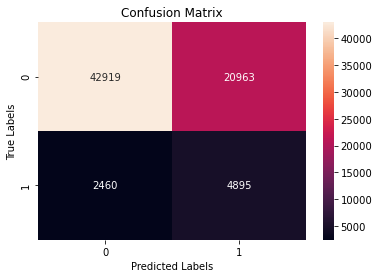

In [25]:
# Prediction
y_pred_knn = knn.predict(X_test)

# Model evaluation
evaluate_model(y_test, y_pred_knn)

AUC score: 0.6686908727514281


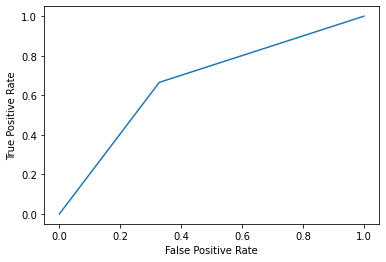

In [26]:
plot_roc_curve(y_test, y_pred_knn)
print(f'AUC score: {met.roc_auc_score(y_test, y_pred_knn)}')

# GTCC

## Data Preprocessing

In [27]:
# Load MFCC and GTCC features from CSV files
col_names = ['LogEnergy'] + [f'GTCC{i}' for i in range(13)] + ['LogEnergy_delta'] + [f'GTCC{i}_delta' for i in range(13)] + ['LogEnergy_delta-delta'] + [f'GTCC{i}_delta-delta' for i in range(13)] + ['label']

train = pd.read_csv("./extracted_features/GTCC_train.csv", header=None, names=col_names)
val = pd.read_csv("./extracted_features/GTCC_val.csv", header=None, names=col_names)
test = pd.read_csv("./extracted_features/GTCC_test.csv", header=None, names=col_names)

In [28]:
col_names = ['LogEnergy'] + [f'GTCC{i}' for i in range(13)] + ['LogEnergy_delta'] + [f'GTCC{i}_delta' for i in range(13)] + ['LogEnergy_delta-delta'] + [f'GTCC{i}_delta-delta' for i in range(13)]
# Normalization using StandardScaler
X_train = train.drop('label', axis=1)
y_train = train['label']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Concatenate the scaled features with the labels
train_scaled = pd.concat([pd.DataFrame(X_train, columns=col_names), y_train], axis=1)

In [29]:
# Normalized data
train_scaled.head()

,LogEnergy,GTCC0,GTCC1,GTCC2,GTCC3,GTCC4,GTCC5,GTCC6,GTCC7,GTCC8,...,GTCC4_delta-delta,GTCC5_delta-delta,GTCC6_delta-delta,GTCC7_delta-delta,GTCC8_delta-delta,GTCC9_delta-delta,GTCC10_delta-delta,GTCC11_delta-delta,GTCC12_delta-delta,label
0,-0.128510,0.073872,-0.236758,0.851631,0.513468,0.861742,0.227095,0.762275,1.002205,0.122225,...,0.166344,0.605967,0.256665,0.884314,0.957952,0.146674,-1.110370,-0.754743,-0.048792,0
1,-0.029417,0.033635,0.518809,0.775044,-0.227556,-0.899901,-1.305552,1.331716,0.514825,-1.485395,...,-0.088871,-0.055616,-0.013082,-0.023848,0.033565,-0.164380,-0.276437,0.087448,0.830355,0
2,0.379600,0.248687,-0.508618,-0.195609,-0.302293,-0.905960,0.002100,0.147866,-0.938601,-0.878436,...,0.326026,0.554104,0.059736,-0.146534,-0.168184,-0.323647,-0.689073,-0.504196,-0.989830,0
3,-0.198182,-0.056271,-0.149156,1.077413,-0.129536,0.555747,1.067700,0.010510,-0.880083,0.239690,...,0.131893,0.061573,-0.144452,-0.028578,0.188921,-0.152417,-0.437317,-0.359331,-0.333359,0
4,0.316611,0.183990,1.104448,0.182811,-0.683060,0.694967,-1.147925,-0.482096,-1.926380,-1.261906,...,-0.909980,0.231869,0.052452,0.756659,0.012244,-0.398684,-1.024238,0.061952,-1.187351,0


In [30]:
# Validation data
X_val = val.drop('label', axis=1)  # Features
y_val = val['label']   # Labels

# Normalize validation data
X_val = scaler.transform(X_val)
val_scaled = pd.concat([pd.DataFrame(X_val), y_val], axis=1)

In [31]:
# Test data
X_test = test.drop('label', axis=1)  # Features
y_test = test['label']   # Labels

# Normalize validation data
X_test = scaler.transform(X_test)
test_scaled = pd.concat([pd.DataFrame(X_test), y_test], axis=1)

In [32]:
# SMOTE data augmentation
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# Apply SMOTE
smote = SMOTE(random_state=42, sampling_strategy='minority')
X_train, y_train = smote.fit_resample(X_train, y_train)

# Concatenate the resampled features and labels
train_resampled = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train, columns=['label'])], axis=1)

print('After OverSampling, the shape of X_train: {}'.format(X_train.shape))
print('After OverSampling, the shape of y_train: {} \n'.format(y_train.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train == 0)))

Before OverSampling, counts of label '1': 2580
Before OverSampling, counts of label '0': 22800 

After OverSampling, the shape of X_train: (45600, 42)
After OverSampling, the shape of y_train: (45600,) 

After OverSampling, counts of label '1': 22800
After OverSampling, counts of label '0': 22800


## Modeling

### 1.0 XGBoost

#### Hyperparameter Tuning

In [33]:
# Define hyperparameter values
n_estimators = [100, 200, 300, 400, 600, 800, 1000]
max_depth = [None, 3, 6, 9, 12, 15]
min_child_weight = [1, 3, 5]
gamma = [0.1, 0.5, 1] 
subsample = [0.8]
colsample_bytree = [0.8]

# Create a list of all combinations of hyperparameters
hyperparameter_combinations = list(product(n_estimators, max_depth, min_child_weight, gamma, subsample, colsample_bytree))

# Total number of combinations
total_combinations = len(hyperparameter_combinations)

best_score = 0
best_params = {}

# Loop through all combinations
for i, (n_estimators, max_depth, min_child_weight, gamma, subsample, colsample_bytree) in enumerate(hyperparameter_combinations, 1):
    print(f"Progress: {i}/{total_combinations}")
    print(f"n_estimators: {n_estimators}, max_depth: {max_depth}, min_child_weight: {min_child_weight}, gamma: {gamma}, subsample: {subsample}, colsample_bytree: {colsample_bytree}")
    
    # Create RandomForestClassifier with current hyperparameters
    xgb = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        objective='binary:logistic',
        seed=42
    )

    # Fit on training data
    xgb.fit(X_train, y_train)

    # Predict on validation set
    y_val_pred = xgb.predict(X_val)

    # Evaluate accuracy on validation set
    f1 = met.f1_score(y_val, y_val_pred, average='macro')
    print("Current score: ", f1)

    # Check if current model is the best
    if f1 > best_score:
        best_score = f1
        best_params = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'min_child_weight': min_child_weight,
            'gamma': gamma,
            'subsample': subsample,
            'colsample_bytree': colsample_bytree
        }

    # Add a new line for better readability
    print("\n")

# Display the best parameters found 
print("Best parameters:", best_params)
print("Best score on Validation Set:", best_score)

Progress: 1/378
n_estimators: 100, max_depth: None, min_child_weight: 1, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.7019564041468371


Progress: 2/378
n_estimators: 100, max_depth: None, min_child_weight: 1, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.697270411933198


Progress: 3/378
n_estimators: 100, max_depth: None, min_child_weight: 1, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.7064531110811747


Progress: 4/378
n_estimators: 100, max_depth: None, min_child_weight: 3, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.7111274234079265


Progress: 5/378
n_estimators: 100, max_depth: None, min_child_weight: 3, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.7059315214941314


Progress: 6/378
n_estimators: 100, max_depth: None, min_child_weight: 3, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.7120143403203667


Progress: 7/378
n_estimators: 100, max_depth:

Current score:  0.6981071505429424


Progress: 54/378
n_estimators: 100, max_depth: 15, min_child_weight: 5, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.7070504013332679


Progress: 55/378
n_estimators: 200, max_depth: None, min_child_weight: 1, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.700228050629653


Progress: 56/378
n_estimators: 200, max_depth: None, min_child_weight: 1, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6916349310560934


Progress: 57/378
n_estimators: 200, max_depth: None, min_child_weight: 1, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6979979368543717


Progress: 58/378
n_estimators: 200, max_depth: None, min_child_weight: 3, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.7010961522511061


Progress: 59/378
n_estimators: 200, max_depth: None, min_child_weight: 3, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.7049990459574385


Prog

Current score:  0.6988550251119104


Progress: 106/378
n_estimators: 200, max_depth: 15, min_child_weight: 5, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6950779680315855


Progress: 107/378
n_estimators: 200, max_depth: 15, min_child_weight: 5, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6987823123833445


Progress: 108/378
n_estimators: 200, max_depth: 15, min_child_weight: 5, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.7072709192226257


Progress: 109/378
n_estimators: 300, max_depth: None, min_child_weight: 1, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.7007860252735081


Progress: 110/378
n_estimators: 300, max_depth: None, min_child_weight: 1, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6928892440848502


Progress: 111/378
n_estimators: 300, max_depth: None, min_child_weight: 1, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6953525399666064


P

Current score:  0.7023571603069914


Progress: 158/378
n_estimators: 300, max_depth: 15, min_child_weight: 3, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6959062086729304


Progress: 159/378
n_estimators: 300, max_depth: 15, min_child_weight: 3, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.697093261954617


Progress: 160/378
n_estimators: 300, max_depth: 15, min_child_weight: 5, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6934731647131401


Progress: 161/378
n_estimators: 300, max_depth: 15, min_child_weight: 5, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6990857335233543


Progress: 162/378
n_estimators: 300, max_depth: 15, min_child_weight: 5, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.7066102772891315


Progress: 163/378
n_estimators: 400, max_depth: None, min_child_weight: 1, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6941558571164226


Progre

Current score:  0.6994425036257552


Progress: 210/378
n_estimators: 400, max_depth: 15, min_child_weight: 1, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6957163227094831


Progress: 211/378
n_estimators: 400, max_depth: 15, min_child_weight: 3, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.7002524408805733


Progress: 212/378
n_estimators: 400, max_depth: 15, min_child_weight: 3, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6967575092206361


Progress: 213/378
n_estimators: 400, max_depth: 15, min_child_weight: 3, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6975123258314547


Progress: 214/378
n_estimators: 400, max_depth: 15, min_child_weight: 5, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6946903684740667


Progress: 215/378
n_estimators: 400, max_depth: 15, min_child_weight: 5, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6981123797918426


Progres

Current score:  0.6893487293820023


Progress: 262/378
n_estimators: 600, max_depth: 15, min_child_weight: 1, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.700346819521234


Progress: 263/378
n_estimators: 600, max_depth: 15, min_child_weight: 1, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6991440331905815


Progress: 264/378
n_estimators: 600, max_depth: 15, min_child_weight: 1, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6965415642469925


Progress: 265/378
n_estimators: 600, max_depth: 15, min_child_weight: 3, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.7003745269035409


Progress: 266/378
n_estimators: 600, max_depth: 15, min_child_weight: 3, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6968172299817542


Progress: 267/378
n_estimators: 600, max_depth: 15, min_child_weight: 3, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6975160501075313


Progress

Current score:  0.688272561879887


Progress: 314/378
n_estimators: 800, max_depth: 12, min_child_weight: 5, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.7025354669401381


Progress: 315/378
n_estimators: 800, max_depth: 12, min_child_weight: 5, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6897173223225388


Progress: 316/378
n_estimators: 800, max_depth: 15, min_child_weight: 1, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.7002867946094203


Progress: 317/378
n_estimators: 800, max_depth: 15, min_child_weight: 1, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6993369607338433


Progress: 318/378
n_estimators: 800, max_depth: 15, min_child_weight: 1, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6965415642469925


Progress: 319/378
n_estimators: 800, max_depth: 15, min_child_weight: 3, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.7002487732843051


Progress

Current score:  0.6970722539101927


Progress: 366/378
n_estimators: 1000, max_depth: 12, min_child_weight: 3, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6967856282234597


Progress: 367/378
n_estimators: 1000, max_depth: 12, min_child_weight: 5, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.688899938175169


Progress: 368/378
n_estimators: 1000, max_depth: 12, min_child_weight: 5, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.7035239402138441


Progress: 369/378
n_estimators: 1000, max_depth: 12, min_child_weight: 5, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6890468253454938


Progress: 370/378
n_estimators: 1000, max_depth: 15, min_child_weight: 1, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6989760495471377


Progress: 371/378
n_estimators: 1000, max_depth: 15, min_child_weight: 1, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6982394419028689


Pr

#### Model

In [34]:
# Model with best params
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=3,
    min_child_weight=3,
    gamma=1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    seed=42
)

# Fit the model
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Test Accuracy: 80.7081%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.82      0.88     63882
           1       0.31      0.73      0.44      7355

    accuracy                           0.81     71237
   macro avg       0.64      0.77      0.66     71237
weighted avg       0.90      0.81      0.84     71237



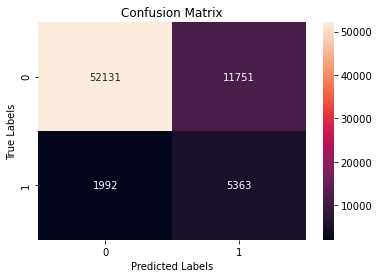

In [35]:
# Make predictions on the test set
y_pred_xgb = xgb.predict(X_test)

# Model evaluation
evaluate_model(y_test, y_pred_xgb)

AUC score: 0.7726076520120342


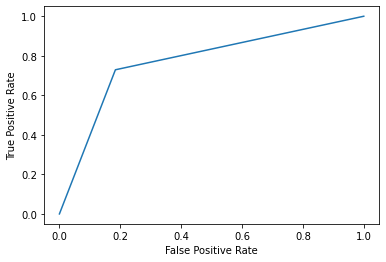

In [36]:
plot_roc_curve(y_test, y_pred_xgb)
print(f'AUC score: {met.roc_auc_score(y_test, y_pred_xgb)}')

### 2.0 Random Forest

#### Hyperparameter Tuning

In [37]:
# Define hyperparameter values
n_estimators = [100, 200, 300, 400, 600, 800, 1000]
max_depths = [None, 10, 20, 30]
min_samples_splits = [2, 5, 10]
min_samples_leafs = [1, 2, 4]

# Create a list of all combinations of hyperparameters
hyperparameter_combinations = list(product(n_estimators, max_depths, min_samples_splits, min_samples_leafs))

# Total number of combinations
total_combinations = len(hyperparameter_combinations)

best_score = 0
best_params = {}

# Loop through all combinations
for i, (n_estimators, max_depth, min_samples_split, min_samples_leaf) in enumerate(hyperparameter_combinations, 1):
    print(f"Progress: {i}/{total_combinations}")
    print(f"n_estimators: {n_estimators}, max_depth: {max_depth}, min_samples_split: {min_samples_split}, min_samples_leaf: {min_samples_leaf}")
    
    # Create RandomForestClassifier with current hyperparameters
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Fit on training data
    rf.fit(X_train, y_train)

    # Predict on validation set
    y_val_pred = rf.predict(X_val)

    # Evaluate accuracy on validation set
    f1 = met.f1_score(y_val, y_val_pred, average='macro')
    print("Current score: ", f1)

    # Check if current model is the best
    if f1 > best_score:
        best_score = f1
        best_params = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf
        }

    # Add a new line for better readability
    print("\n")

# Display the best parameters found 
print("Best parameters:", best_params)
print("Best score on Validation Set:", best_score)

Progress: 1/252
n_estimators: 100, max_depth: None, min_samples_split: 2, min_samples_leaf: 1
Current score:  0.7174455629619382


Progress: 2/252
n_estimators: 100, max_depth: None, min_samples_split: 2, min_samples_leaf: 2
Current score:  0.7192060869601198


Progress: 3/252
n_estimators: 100, max_depth: None, min_samples_split: 2, min_samples_leaf: 4
Current score:  0.7271071628424486


Progress: 4/252
n_estimators: 100, max_depth: None, min_samples_split: 5, min_samples_leaf: 1
Current score:  0.713915757012371


Progress: 5/252
n_estimators: 100, max_depth: None, min_samples_split: 5, min_samples_leaf: 2
Current score:  0.7182911044498059


Progress: 6/252
n_estimators: 100, max_depth: None, min_samples_split: 5, min_samples_leaf: 4
Current score:  0.7271071628424486


Progress: 7/252
n_estimators: 100, max_depth: None, min_samples_split: 10, min_samples_leaf: 1
Current score:  0.7105922826419239


Progress: 8/252
n_estimators: 100, max_depth: None, min_samples_split: 10, min_samp

Current score:  0.7192351906048122


Progress: 64/252
n_estimators: 200, max_depth: 30, min_samples_split: 2, min_samples_leaf: 1
Current score:  0.7205430317317731


Progress: 65/252
n_estimators: 200, max_depth: 30, min_samples_split: 2, min_samples_leaf: 2
Current score:  0.7203161745153803


Progress: 66/252
n_estimators: 200, max_depth: 30, min_samples_split: 2, min_samples_leaf: 4
Current score:  0.7269663924906307


Progress: 67/252
n_estimators: 200, max_depth: 30, min_samples_split: 5, min_samples_leaf: 1
Current score:  0.7174613965985719


Progress: 68/252
n_estimators: 200, max_depth: 30, min_samples_split: 5, min_samples_leaf: 2
Current score:  0.7214587233504871


Progress: 69/252
n_estimators: 200, max_depth: 30, min_samples_split: 5, min_samples_leaf: 4
Current score:  0.7269663924906307


Progress: 70/252
n_estimators: 200, max_depth: 30, min_samples_split: 10, min_samples_leaf: 1
Current score:  0.7122966306936085


Progress: 71/252
n_estimators: 200, max_depth: 30, m

Current score:  0.7026413376056089


Progress: 127/252
n_estimators: 400, max_depth: 20, min_samples_split: 2, min_samples_leaf: 1
Current score:  0.72160927152306


Progress: 128/252
n_estimators: 400, max_depth: 20, min_samples_split: 2, min_samples_leaf: 2
Current score:  0.7249305871308908


Progress: 129/252
n_estimators: 400, max_depth: 20, min_samples_split: 2, min_samples_leaf: 4
Current score:  0.7217769078367663


Progress: 130/252
n_estimators: 400, max_depth: 20, min_samples_split: 5, min_samples_leaf: 1
Current score:  0.7209149093526412


Progress: 131/252
n_estimators: 400, max_depth: 20, min_samples_split: 5, min_samples_leaf: 2
Current score:  0.7229976370950004


Progress: 132/252
n_estimators: 400, max_depth: 20, min_samples_split: 5, min_samples_leaf: 4
Current score:  0.7217769078367663


Progress: 133/252
n_estimators: 400, max_depth: 20, min_samples_split: 10, min_samples_leaf: 1
Current score:  0.7191987087332948


Progress: 134/252
n_estimators: 400, max_depth:

Current score:  0.7276979294345371


Progress: 190/252
n_estimators: 800, max_depth: 10, min_samples_split: 2, min_samples_leaf: 1
Current score:  0.7030718874900621


Progress: 191/252
n_estimators: 800, max_depth: 10, min_samples_split: 2, min_samples_leaf: 2
Current score:  0.7037737695747652


Progress: 192/252
n_estimators: 800, max_depth: 10, min_samples_split: 2, min_samples_leaf: 4
Current score:  0.704004580126107


Progress: 193/252
n_estimators: 800, max_depth: 10, min_samples_split: 5, min_samples_leaf: 1
Current score:  0.7034088246193417


Progress: 194/252
n_estimators: 800, max_depth: 10, min_samples_split: 5, min_samples_leaf: 2
Current score:  0.7029071083301368


Progress: 195/252
n_estimators: 800, max_depth: 10, min_samples_split: 5, min_samples_leaf: 4
Current score:  0.704004580126107


Progress: 196/252
n_estimators: 800, max_depth: 10, min_samples_split: 10, min_samples_leaf: 1
Current score:  0.7035381915421562


Progress: 197/252
n_estimators: 800, max_depth:

Current score:  0.726393551444735


Best parameters: {'n_estimators': 400, 'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 4}
Best score on Validation Set: 0.7282457233608665


#### Model

In [38]:
# Model with best params
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42
)

# Fit training set
rf.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=4, min_samples_split=10,
                       n_estimators=400, random_state=42)

Test Accuracy: 82.6719%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.84      0.90     63882
           1       0.34      0.69      0.45      7355

    accuracy                           0.83     71237
   macro avg       0.65      0.77      0.67     71237
weighted avg       0.89      0.83      0.85     71237



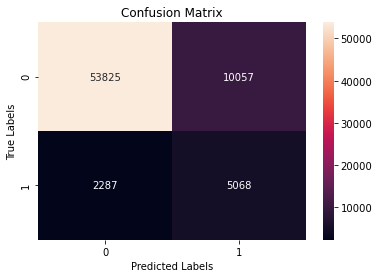

In [39]:
# Make predictions on the test set
y_pred_rf_gtcc = rf.predict(X_test)

# Model evaluation
evaluate_model(y_test, y_pred_rf_gtcc)

AUC score: 0.765812088190899


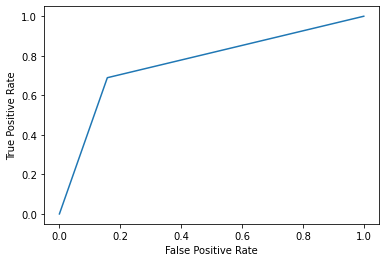

In [40]:
plot_roc_curve(y_test, y_pred_rf_gtcc)
print(f'AUC score: {met.roc_auc_score(y_test, y_pred_rf_gtcc)}')

### 3.0 SVM

#### Hyperparameter Tuning

In [41]:
# Define hyperparameter values
kernels = ['poly', 'rbf']
Cs = [0.01, 0.1, 1, 10, 100]
gammas = ['scale', 'auto']

# Create a list of all combinations of hyperparameters
hyperparameter_combinations = list(product(kernels, Cs, gammas))

# Total number of combinations
total_combinations = len(hyperparameter_combinations)

best_score = 0
best_params = {}

# Loop through all combinations
for i, (kernel, C, gamma) in enumerate(hyperparameter_combinations, 1):
    print(f"Progress: {i}/{total_combinations}")
    print(f"kernel: {kernel}, C: {C}, gamma: {gamma}")
    
    # Create RandomForestClassifier with current hyperparameters
    svm = SVC(
        kernel=kernel,
        C=C,
        gamma=gamma
    )

    # Fit on training data
    svm.fit(X_train, y_train)

    # Predict on validation set
    y_val_pred = svm.predict(X_val)

    # Evaluate accuracy on validation set
    f1 = met.f1_score(y_val, y_val_pred, average='macro')
    print("Current score: ", f1)

    # Check if current model is the best
    if f1 > best_score:
        best_score = f1
        best_params = {
            'kernel': kernel,
            'C': C,
            'gamma': gamma
        }

    # Add a new line for better readability
    print("\n")

# Display the best parameters found 
print("Best parameters:", best_params)
print("Best score on Validation Set:", best_score)

Progress: 1/20
kernel: poly, C: 0.01, gamma: scale
Current score:  0.46807226470540486


Progress: 2/20
kernel: poly, C: 0.01, gamma: auto
Current score:  0.3845542275349163


Progress: 3/20
kernel: poly, C: 0.1, gamma: scale
Current score:  0.5854749122660428


Progress: 4/20
kernel: poly, C: 0.1, gamma: auto
Current score:  0.5578654705539237


Progress: 5/20
kernel: poly, C: 1, gamma: scale
Current score:  0.6329503357524228


Progress: 6/20
kernel: poly, C: 1, gamma: auto
Current score:  0.621554364058722


Progress: 7/20
kernel: poly, C: 10, gamma: scale
Current score:  0.6533169567309104


Progress: 8/20
kernel: poly, C: 10, gamma: auto
Current score:  0.6492116430172183


Progress: 9/20
kernel: poly, C: 100, gamma: scale
Current score:  0.6387374797670631


Progress: 10/20
kernel: poly, C: 100, gamma: auto
Current score:  0.6442420806737197


Progress: 11/20
kernel: rbf, C: 0.01, gamma: scale
Current score:  0.6424753287635465


Progress: 12/20
kernel: rbf, C: 0.01, gamma: auto


#### Model

In [42]:
# Model with best params
svm = SVC(
    kernel='rbf',
    C=1,
    gamma='auto',
)

# Fit training dataset
svm.fit(X_train, y_train)

SVC(C=1, gamma='auto')

Test Accuracy: 78.1153%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.79      0.87     63882
           1       0.28      0.70      0.40      7355

    accuracy                           0.78     71237
   macro avg       0.62      0.74      0.63     71237
weighted avg       0.89      0.78      0.82     71237



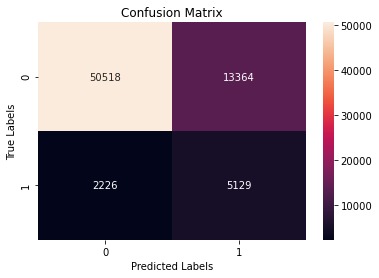

In [43]:
# Prediction
y_pred_svm = svm.predict(X_test)

# Model evaluation
evaluate_model(y_test, y_pred_svm)

AUC score: 0.7440752665769661


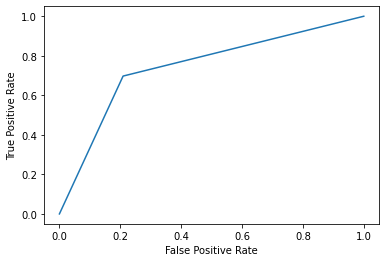

In [44]:
plot_roc_curve(y_test, y_pred_svm)
print(f'AUC score: {met.roc_auc_score(y_test, y_pred_svm)}')

### 4.0 KNN

#### Hyperparameter Tuning

In [45]:
# Define hyperparameter values
n_neighbors = np.arange(2, 20, 1)
weights = ['uniform', 'distance']
p = [1, 2]

# Create a list of all combinations of hyperparameters
hyperparameter_combinations = list(product(n_neighbors, weights, p))

# Total number of combinations
total_combinations = len(hyperparameter_combinations)

best_score = 0
best_params = {}

# Loop through all combinations
for i, (n_neighbors, weights, p) in enumerate(hyperparameter_combinations, 1):
    print(f"Progress: {i}/{total_combinations}")
    print(f"n_neighbors: {n_neighbors}, weights: {weights}, p: {p}")
    
    # Create RandomForestClassifier with current hyperparameters
    knn = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        p=p
    )

    # Fit on training data
    knn.fit(X_train, y_train)

    # Predict on validation set
    y_val_pred = knn.predict(X_val)

    # Evaluate accuracy on validation set
    f1 = met.f1_score(y_val, y_val_pred, average='macro')
    print("Current score: ", f1)

    # Check if current model is the best
    if f1 > best_score:
        best_score = f1
        best_params = {
            'n_neighbors': n_neighbors,
            'weights': weights,
            'p': p
        }

    # Add a new line for better readability
    print("\n")

# Display the best parameters found 
print("Best parameters:", best_params)
print("Best score on Validation Set:", best_score)

Progress: 1/72
n_neighbors: 2, weights: uniform, p: 1
Current score:  0.6266598755098349


Progress: 2/72
n_neighbors: 2, weights: uniform, p: 2
Current score:  0.6159088288418137


Progress: 3/72
n_neighbors: 2, weights: distance, p: 1
Current score:  0.6334089726312218


Progress: 4/72
n_neighbors: 2, weights: distance, p: 2
Current score:  0.6181216437725847


Progress: 5/72
n_neighbors: 3, weights: uniform, p: 1
Current score:  0.6392243322438614


Progress: 6/72
n_neighbors: 3, weights: uniform, p: 2
Current score:  0.6187659188864714


Progress: 7/72
n_neighbors: 3, weights: distance, p: 1
Current score:  0.6398605328282317


Progress: 8/72
n_neighbors: 3, weights: distance, p: 2
Current score:  0.6191821830720492


Progress: 9/72
n_neighbors: 4, weights: uniform, p: 1
Current score:  0.6386223489031705


Progress: 10/72
n_neighbors: 4, weights: uniform, p: 2
Current score:  0.6229343496659159


Progress: 11/72
n_neighbors: 4, weights: distance, p: 1
Current score:  0.63880031825

#### Model

In [46]:
# Model with best params
knn = KNeighborsClassifier(
    n_neighbors=6,
    weights='uniform',
    p=1
)

# Fit training dataset
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=6, p=1)

Test Accuracy: 67.5857%

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.67      0.79     63882
           1       0.20      0.72      0.31      7355

    accuracy                           0.68     71237
   macro avg       0.58      0.69      0.55     71237
weighted avg       0.88      0.68      0.74     71237



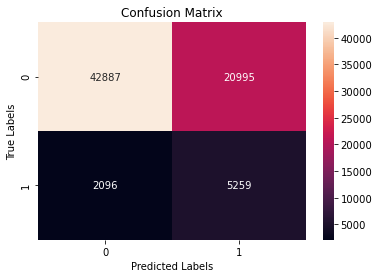

In [47]:
# Prediction
y_pred_knn = knn.predict(X_test)

# Model evaluation
evaluate_model(y_test, y_pred_knn)

AUC score: 0.6931854823425184


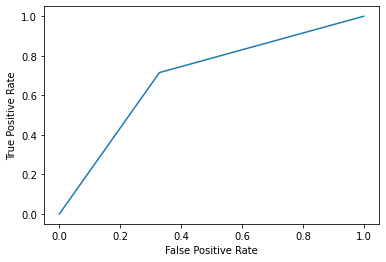

In [48]:
plot_roc_curve(y_test, y_pred_knn)
print(f'AUC score: {met.roc_auc_score(y_test, y_pred_knn)}')

# MFCC

## Data Preprocessing

In [49]:
# Load MFCC and GTCC features from CSV files
col_names = ['LogEnergy'] + [f'MFCC{i}' for i in range(13)] + ['LogEnergy_delta'] + [f'MFCC{i}_delta' for i in range(13)] + ['LogEnergy_delta-delta'] + [f'MFCC{i}_delta-delta' for i in range(13)] + ['label']

train = pd.read_csv("./extracted_features/MFCC_train.csv", header=None, names=col_names)
val = pd.read_csv("./extracted_features/MFCC_val.csv", header=None, names=col_names)
test = pd.read_csv("./extracted_features/MFCC_test.csv", header=None, names=col_names)

In [50]:
col_names = ['LogEnergy'] + [f'MFCC{i}' for i in range(13)] + ['LogEnergy_delta'] + [f'MFCC{i}_delta' for i in range(13)] + ['LogEnergy_delta-delta'] + [f'MFCC{i}_delta-delta' for i in range(13)]

# Normalization using StandardScaler
X_train = train.drop('label', axis=1)
y_train = train['label']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Concatenate the scaled features with the labels
train_scaled = pd.concat([pd.DataFrame(X_train, columns=col_names), y_train], axis=1)

In [51]:
# Normalized data
train_scaled.head()

,LogEnergy,MFCC0,MFCC1,MFCC2,MFCC3,MFCC4,MFCC5,MFCC6,MFCC7,MFCC8,...,MFCC4_delta-delta,MFCC5_delta-delta,MFCC6_delta-delta,MFCC7_delta-delta,MFCC8_delta-delta,MFCC9_delta-delta,MFCC10_delta-delta,MFCC11_delta-delta,MFCC12_delta-delta,label
0,-0.128510,0.074533,-0.746832,0.121862,-0.405941,1.095242,-1.065704,0.589097,-0.371454,-0.113860,...,-0.026832,0.790067,0.110165,-0.595030,-1.088868,-0.601788,-1.789699,0.316753,-0.132822,0
1,-0.029417,0.012821,0.089632,1.251983,1.787084,1.327288,-2.640026,-1.216873,0.414640,-0.194669,...,-0.067333,0.132257,-0.051792,-0.305196,-0.466887,0.431240,0.404350,0.061240,-0.208908,0
2,0.379600,0.259622,-0.491503,0.576024,0.459548,-1.160296,-0.910345,0.722896,1.170746,-0.356501,...,-0.371035,0.130630,0.074267,-0.054581,0.134074,0.216466,-0.218511,0.737281,-0.340147,0
3,-0.198182,-0.068481,-0.581800,0.845508,-0.730788,-1.310908,0.544822,0.931022,0.865510,0.367253,...,0.058219,0.368789,0.119126,-0.124527,-0.087493,-0.368293,-0.300123,0.092421,0.070479,0
4,0.316611,0.167498,1.404652,0.210416,-0.796431,1.354172,-0.889378,1.324782,-0.517526,2.427732,...,-0.805542,-0.897721,-1.134657,-1.145954,-0.142735,-1.032443,-1.285619,-0.370139,-0.810454,0


In [52]:
# Validation data
X_val = val.drop('label', axis=1)  # Features
y_val = val['label']   # Labels

# Normalize validation data
X_val = scaler.transform(X_val)
val_scaled = pd.concat([pd.DataFrame(X_val), y_val], axis=1)

In [53]:
# Test data
X_test = test.drop('label', axis=1)  # Features
y_test = test['label']   # Labels

# Normalize validation data
X_test = scaler.transform(X_test)
test_scaled = pd.concat([pd.DataFrame(X_test), y_test], axis=1)

In [54]:
# SMOTE data augmentation
print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# Apply SMOTE
smote = SMOTE(random_state=42, sampling_strategy='minority')
X_train, y_train = smote.fit_resample(X_train, y_train)

# Concatenate the resampled features and labels
train_resampled = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train, columns=['label'])], axis=1)

print('After OverSampling, the shape of X_train: {}'.format(X_train.shape))
print('After OverSampling, the shape of y_train: {} \n'.format(y_train.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train == 0)))

Before OverSampling, counts of label '1': 2580
Before OverSampling, counts of label '0': 22800 

After OverSampling, the shape of X_train: (45600, 42)
After OverSampling, the shape of y_train: (45600,) 

After OverSampling, counts of label '1': 22800
After OverSampling, counts of label '0': 22800


## Modeling

Test Accuracy: 88.9285%

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     63882
           1       0.43      0.22      0.29      7355

    accuracy                           0.89     71237
   macro avg       0.67      0.59      0.62     71237
weighted avg       0.86      0.89      0.87     71237



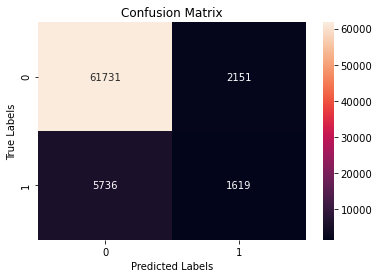

AUC score: 0.5932254544946068


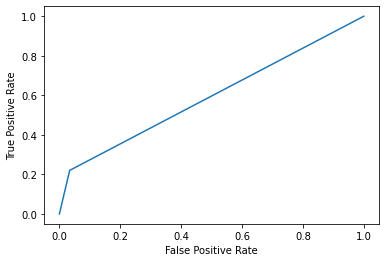

In [55]:
# Baseline without SMOTE using XGBoost and MFCC features
xgb = XGBClassifier()
xgb.fit(train_scaled.drop('label', axis=1), train_scaled['label'])

# Prediction
y_pred = xgb.predict(X_test)

# Model evaluation
evaluate_model(y_test, y_pred)

# Plot ROC curve
plot_roc_curve(y_test, y_pred)
print(f'AUC score: {met.roc_auc_score(y_test, y_pred)}')

### 1.0 XGBoost

#### Hyperparameter Tuning

In [56]:
# Define hyperparameter values
n_estimators = [100, 200, 300, 400, 600, 800, 1000]
max_depth = [None, 3, 6, 9, 12, 15]
min_child_weight = [1, 3, 5]
gamma = [0.1, 0.5, 1] 
subsample = [0.8]
colsample_bytree = [0.8]

# Create a list of all combinations of hyperparameters
hyperparameter_combinations = list(product(n_estimators, max_depth, min_child_weight, gamma, subsample, colsample_bytree))

# Total number of combinations
total_combinations = len(hyperparameter_combinations)

best_score = 0
best_params = {}

# Loop through all combinations
for i, (n_estimators, max_depth, min_child_weight, gamma, subsample, colsample_bytree) in enumerate(hyperparameter_combinations, 1):
    print(f"Progress: {i}/{total_combinations}")
    print(f"n_estimators: {n_estimators}, max_depth: {max_depth}, min_child_weight: {min_child_weight}, gamma: {gamma}, subsample: {subsample}, colsample_bytree: {colsample_bytree}")
    
    # Create RandomForestClassifier with current hyperparameters
    xgb = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_child_weight=min_child_weight,
        gamma=gamma,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        objective='binary:logistic',
        seed=42
    )

    # Fit on training data
    xgb.fit(X_train, y_train)

    # Predict on validation set
    y_val_pred = xgb.predict(X_val)

    # Evaluate accuracy on validation set
    f1 = met.f1_score(y_val, y_val_pred, average='macro')
    print("Current score: ", f1)

    # Check if current model is the best
    if f1 > best_score:
        best_score = f1
        best_params = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'min_child_weight': min_child_weight,
            'gamma': gamma,
            'subsample': subsample,
            'colsample_bytree': colsample_bytree
        }

    # Add a new line for better readability
    print("\n")

# Display the best parameters found 
print("Best parameters:", best_params)
print("Best score on Validation Set:", best_score)

Progress: 1/378
n_estimators: 100, max_depth: None, min_child_weight: 1, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6460185123669467


Progress: 2/378
n_estimators: 100, max_depth: None, min_child_weight: 1, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6495767749955477


Progress: 3/378
n_estimators: 100, max_depth: None, min_child_weight: 1, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6471697783362964


Progress: 4/378
n_estimators: 100, max_depth: None, min_child_weight: 3, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6524066936730823


Progress: 5/378
n_estimators: 100, max_depth: None, min_child_weight: 3, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6537903322996474


Progress: 6/378
n_estimators: 100, max_depth: None, min_child_weight: 3, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6620863617867283


Progress: 7/378
n_estimators: 100, max_depth

Current score:  0.6350302275955296


Progress: 54/378
n_estimators: 100, max_depth: 15, min_child_weight: 5, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6483957293552007


Progress: 55/378
n_estimators: 200, max_depth: None, min_child_weight: 1, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6328262515451335


Progress: 56/378
n_estimators: 200, max_depth: None, min_child_weight: 1, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6342348062343188


Progress: 57/378
n_estimators: 200, max_depth: None, min_child_weight: 1, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.639497544745185


Progress: 58/378
n_estimators: 200, max_depth: None, min_child_weight: 3, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6414154933167254


Progress: 59/378
n_estimators: 200, max_depth: None, min_child_weight: 3, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6428139559622388


Prog

Current score:  0.6434728656715585


Progress: 106/378
n_estimators: 200, max_depth: 15, min_child_weight: 5, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6353838769802953


Progress: 107/378
n_estimators: 200, max_depth: 15, min_child_weight: 5, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6342077759915372


Progress: 108/378
n_estimators: 200, max_depth: 15, min_child_weight: 5, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6473891884106966


Progress: 109/378
n_estimators: 300, max_depth: None, min_child_weight: 1, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.627939093559845


Progress: 110/378
n_estimators: 300, max_depth: None, min_child_weight: 1, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6319375430508644


Progress: 111/378
n_estimators: 300, max_depth: None, min_child_weight: 1, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6384358584705443


Pr

Current score:  0.6421353487456644


Progress: 158/378
n_estimators: 300, max_depth: 15, min_child_weight: 3, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.642527374272075


Progress: 159/378
n_estimators: 300, max_depth: 15, min_child_weight: 3, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.645157336847106


Progress: 160/378
n_estimators: 300, max_depth: 15, min_child_weight: 5, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6330237284930988


Progress: 161/378
n_estimators: 300, max_depth: 15, min_child_weight: 5, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6344253414036066


Progress: 162/378
n_estimators: 300, max_depth: 15, min_child_weight: 5, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6470443348323351


Progress: 163/378
n_estimators: 400, max_depth: None, min_child_weight: 1, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6276631868408171


Progres

Current score:  0.6428293376884653


Progress: 210/378
n_estimators: 400, max_depth: 15, min_child_weight: 1, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.641376831076317


Progress: 211/378
n_estimators: 400, max_depth: 15, min_child_weight: 3, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6417085530630298


Progress: 212/378
n_estimators: 400, max_depth: 15, min_child_weight: 3, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6432051957882217


Progress: 213/378
n_estimators: 400, max_depth: 15, min_child_weight: 3, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6442686065661473


Progress: 214/378
n_estimators: 400, max_depth: 15, min_child_weight: 5, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6306884542779313


Progress: 215/378
n_estimators: 400, max_depth: 15, min_child_weight: 5, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6335211029788664


Progress

Current score:  0.643706640740087


Progress: 262/378
n_estimators: 600, max_depth: 15, min_child_weight: 1, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6368420085652866


Progress: 263/378
n_estimators: 600, max_depth: 15, min_child_weight: 1, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6418909703019665


Progress: 264/378
n_estimators: 600, max_depth: 15, min_child_weight: 1, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.641493777825127


Progress: 265/378
n_estimators: 600, max_depth: 15, min_child_weight: 3, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6405283516740389


Progress: 266/378
n_estimators: 600, max_depth: 15, min_child_weight: 3, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6441131619474783


Progress: 267/378
n_estimators: 600, max_depth: 15, min_child_weight: 3, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.644727591805748


Progress: 

Current score:  0.6305151465304593


Progress: 314/378
n_estimators: 800, max_depth: 12, min_child_weight: 5, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6385631823027218


Progress: 315/378
n_estimators: 800, max_depth: 12, min_child_weight: 5, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6441219896289636


Progress: 316/378
n_estimators: 800, max_depth: 15, min_child_weight: 1, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6371179184600513


Progress: 317/378
n_estimators: 800, max_depth: 15, min_child_weight: 1, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6439826213636938


Progress: 318/378
n_estimators: 800, max_depth: 15, min_child_weight: 1, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.642960001161994


Progress: 319/378
n_estimators: 800, max_depth: 15, min_child_weight: 3, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6401024651425055


Progress

Current score:  0.6393725790629432


Progress: 366/378
n_estimators: 1000, max_depth: 12, min_child_weight: 3, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6434747053578641


Progress: 367/378
n_estimators: 1000, max_depth: 12, min_child_weight: 5, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6312167306927039


Progress: 368/378
n_estimators: 1000, max_depth: 12, min_child_weight: 5, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.639413232146645


Progress: 369/378
n_estimators: 1000, max_depth: 12, min_child_weight: 5, gamma: 1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6435565689800998


Progress: 370/378
n_estimators: 1000, max_depth: 15, min_child_weight: 1, gamma: 0.1, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.636730233260296


Progress: 371/378
n_estimators: 1000, max_depth: 15, min_child_weight: 1, gamma: 0.5, subsample: 0.8, colsample_bytree: 0.8
Current score:  0.6445115998643378


Pro

#### Model

In [57]:
# Model with best params
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=3,
    min_child_weight=1,
    gamma=0.5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    seed=42
)

# Fit the model
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Test Accuracy: 78.9688%

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.80      0.87     63882
           1       0.29      0.73      0.42      7355

    accuracy                           0.79     71237
   macro avg       0.63      0.76      0.64     71237
weighted avg       0.89      0.79      0.82     71237



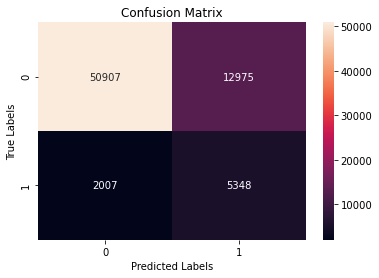

In [58]:
# Make predictions on the test set
y_pred_xgb = xgb.predict(X_test)

# Model evaluation
evaluate_model(y_test, y_pred_xgb)

AUC score: 0.7620077741057714


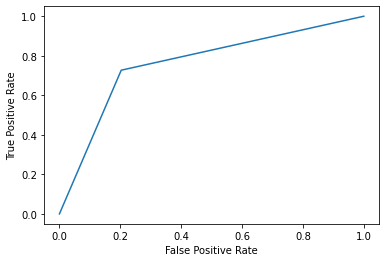

In [59]:
plot_roc_curve(y_test, y_pred_xgb)
print(f'AUC score: {met.roc_auc_score(y_test, y_pred_xgb)}')

### 2.0 Random Forest

#### Hyperparameter Tuning

In [60]:
# Define hyperparameter values
n_estimators = [100, 200, 300, 400, 600, 800, 1000]
max_depths = [None, 10, 20, 30]
min_samples_splits = [2, 5, 10]
min_samples_leafs = [1, 2, 4]

# Create a list of all combinations of hyperparameters
hyperparameter_combinations = list(product(n_estimators, max_depths, min_samples_splits, min_samples_leafs))

# Total number of combinations
total_combinations = len(hyperparameter_combinations)

best_score = 0
best_params = {}

# Loop through all combinations
for i, (n_estimators, max_depth, min_samples_split, min_samples_leaf) in enumerate(hyperparameter_combinations, 1):
    print(f"Progress: {i}/{total_combinations}")
    print(f"n_estimators: {n_estimators}, max_depth: {max_depth}, min_samples_split: {min_samples_split}, min_samples_leaf: {min_samples_leaf}")
    
    # Create RandomForestClassifier with current hyperparameters
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Fit on training data
    rf.fit(X_train, y_train)

    # Predict on validation set
    y_val_pred = rf.predict(X_val)

    # Evaluate accuracy on validation set
    f1 = met.f1_score(y_val, y_val_pred, average='macro')
    print("Current score: ", f1)

    # Check if current model is the best
    if f1 > best_score:
        best_score = f1
        best_params = {
            'n_estimators': n_estimators,
            'max_depth': max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_samples_leaf
        }

    # Add a new line for better readability
    print("\n")

# Display the best parameters found 
print("Best parameters:", best_params)
print("Best score on Validation Set:", best_score)

Progress: 1/252
n_estimators: 100, max_depth: None, min_samples_split: 2, min_samples_leaf: 1
Current score:  0.6536683992697726


Progress: 2/252
n_estimators: 100, max_depth: None, min_samples_split: 2, min_samples_leaf: 2
Current score:  0.6658669538597781


Progress: 3/252
n_estimators: 100, max_depth: None, min_samples_split: 2, min_samples_leaf: 4
Current score:  0.6798064614942312


Progress: 4/252
n_estimators: 100, max_depth: None, min_samples_split: 5, min_samples_leaf: 1
Current score:  0.6556474361261111


Progress: 5/252
n_estimators: 100, max_depth: None, min_samples_split: 5, min_samples_leaf: 2
Current score:  0.6659263890111259


Progress: 6/252
n_estimators: 100, max_depth: None, min_samples_split: 5, min_samples_leaf: 4
Current score:  0.6798064614942312


Progress: 7/252
n_estimators: 100, max_depth: None, min_samples_split: 10, min_samples_leaf: 1
Current score:  0.6613859205400701


Progress: 8/252
n_estimators: 100, max_depth: None, min_samples_split: 10, min_sam

Current score:  0.6909047406717559


Progress: 64/252
n_estimators: 200, max_depth: 30, min_samples_split: 2, min_samples_leaf: 1
Current score:  0.6690252597533503


Progress: 65/252
n_estimators: 200, max_depth: 30, min_samples_split: 2, min_samples_leaf: 2
Current score:  0.6677829432867247


Progress: 66/252
n_estimators: 200, max_depth: 30, min_samples_split: 2, min_samples_leaf: 4
Current score:  0.6834875710852444


Progress: 67/252
n_estimators: 200, max_depth: 30, min_samples_split: 5, min_samples_leaf: 1
Current score:  0.664896216091564


Progress: 68/252
n_estimators: 200, max_depth: 30, min_samples_split: 5, min_samples_leaf: 2
Current score:  0.6742992996489247


Progress: 69/252
n_estimators: 200, max_depth: 30, min_samples_split: 5, min_samples_leaf: 4
Current score:  0.6834875710852444


Progress: 70/252
n_estimators: 200, max_depth: 30, min_samples_split: 10, min_samples_leaf: 1
Current score:  0.6643191199042999


Progress: 71/252
n_estimators: 200, max_depth: 30, mi

Current score:  0.6859521416198134


Progress: 127/252
n_estimators: 400, max_depth: 20, min_samples_split: 2, min_samples_leaf: 1
Current score:  0.6891361185162834


Progress: 128/252
n_estimators: 400, max_depth: 20, min_samples_split: 2, min_samples_leaf: 2
Current score:  0.6845839515208905


Progress: 129/252
n_estimators: 400, max_depth: 20, min_samples_split: 2, min_samples_leaf: 4
Current score:  0.68948677340918


Progress: 130/252
n_estimators: 400, max_depth: 20, min_samples_split: 5, min_samples_leaf: 1
Current score:  0.6845422450933845


Progress: 131/252
n_estimators: 400, max_depth: 20, min_samples_split: 5, min_samples_leaf: 2
Current score:  0.6838897071498926


Progress: 132/252
n_estimators: 400, max_depth: 20, min_samples_split: 5, min_samples_leaf: 4
Current score:  0.68948677340918


Progress: 133/252
n_estimators: 400, max_depth: 20, min_samples_split: 10, min_samples_leaf: 1
Current score:  0.6861039655669556


Progress: 134/252
n_estimators: 400, max_depth: 2

Current score:  0.6817340396231129


Progress: 190/252
n_estimators: 800, max_depth: 10, min_samples_split: 2, min_samples_leaf: 1
Current score:  0.6861442461056548


Progress: 191/252
n_estimators: 800, max_depth: 10, min_samples_split: 2, min_samples_leaf: 2
Current score:  0.6852042557790832


Progress: 192/252
n_estimators: 800, max_depth: 10, min_samples_split: 2, min_samples_leaf: 4
Current score:  0.6856845447520014


Progress: 193/252
n_estimators: 800, max_depth: 10, min_samples_split: 5, min_samples_leaf: 1
Current score:  0.6860262091781206


Progress: 194/252
n_estimators: 800, max_depth: 10, min_samples_split: 5, min_samples_leaf: 2
Current score:  0.6869777591943921


Progress: 195/252
n_estimators: 800, max_depth: 10, min_samples_split: 5, min_samples_leaf: 4
Current score:  0.6856845447520014


Progress: 196/252
n_estimators: 800, max_depth: 10, min_samples_split: 10, min_samples_leaf: 1
Current score:  0.6859841148006212


Progress: 197/252
n_estimators: 800, max_dept

Current score:  0.6831708073679374


Best parameters: {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 4}
Best score on Validation Set: 0.6913968195029353


#### Model

In [61]:
# Model with best params
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42
)

# Fit training set
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=4, min_samples_split=10,
                       n_estimators=300, random_state=42)

Test Accuracy: 82.4291%

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.84      0.90     63882
           1       0.33      0.65      0.43      7355

    accuracy                           0.82     71237
   macro avg       0.64      0.75      0.67     71237
weighted avg       0.89      0.82      0.85     71237



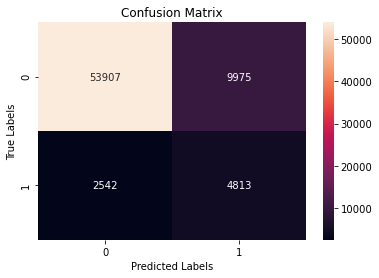

In [62]:
# Make predictions on the test set
y_pred_rf_mfcc = rf.predict(X_test)

# Model evaluation
evaluate_model(y_test, y_pred_rf_mfcc)

AUC score: 0.7491187503659396


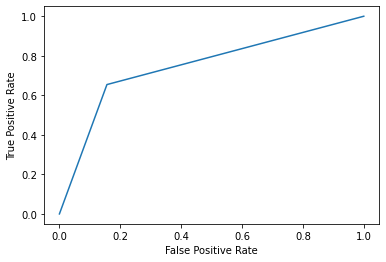

In [63]:
plot_roc_curve(y_test, y_pred_rf_mfcc)
print(f'AUC score: {met.roc_auc_score(y_test, y_pred_rf_mfcc)}')

### 3.0 SVM

#### Hyperparameter Tuning

In [64]:
# Define hyperparameter values
kernels = ['poly', 'rbf']
Cs = [0.01, 0.1, 1, 10, 100]
gammas = ['scale', 'auto']

# Create a list of all combinations of hyperparameters
hyperparameter_combinations = list(product(kernels, Cs, gammas))

# Total number of combinations
total_combinations = len(hyperparameter_combinations)

best_score = 0
best_params = {}

# Loop through all combinations
for i, (kernel, C, gamma) in enumerate(hyperparameter_combinations, 1):
    print(f"Progress: {i}/{total_combinations}")
    print(f"kernel: {kernel}, C: {C}, gamma: {gamma}")
    
    # Create RandomForestClassifier with current hyperparameters
    svm = SVC(
        kernel=kernel,
        C=C,
        gamma=gamma
    )

    # Fit on training data
    svm.fit(X_train, y_train)

    # Predict on validation set
    y_val_pred = svm.predict(X_val)

    # Evaluate accuracy on validation set
    f1 = met.f1_score(y_val, y_val_pred, average='macro')
    print("Current score: ", f1)

    # Check if current model is the best
    if f1 > best_score:
        best_score = f1
        best_params = {
            'kernel': kernel,
            'C': C,
            'gamma': gamma
        }

    # Add a new line for better readability
    print("\n")

# Display the best parameters found 
print("Best parameters:", best_params)
print("Best score on Validation Set:", best_score)

Progress: 1/20
kernel: poly, C: 0.01, gamma: scale
Current score:  0.32913073384093394


Progress: 2/20
kernel: poly, C: 0.01, gamma: auto
Current score:  0.2683001879286771


Progress: 3/20
kernel: poly, C: 0.1, gamma: scale
Current score:  0.5676266682707813


Progress: 4/20
kernel: poly, C: 0.1, gamma: auto
Current score:  0.5133050302685672


Progress: 5/20
kernel: poly, C: 1, gamma: scale
Current score:  0.5976559640839336


Progress: 6/20
kernel: poly, C: 1, gamma: auto
Current score:  0.5991507289643949


Progress: 7/20
kernel: poly, C: 10, gamma: scale
Current score:  0.5741788119136348


Progress: 8/20
kernel: poly, C: 10, gamma: auto
Current score:  0.5797574567024827


Progress: 9/20
kernel: poly, C: 100, gamma: scale
Current score:  0.5589557031112102


Progress: 10/20
kernel: poly, C: 100, gamma: auto
Current score:  0.5630332622552938


Progress: 11/20
kernel: rbf, C: 0.01, gamma: scale
Current score:  0.6025434853435954


Progress: 12/20
kernel: rbf, C: 0.01, gamma: auto

#### Model

In [65]:
# Model with best params
svm = SVC(
    kernel='rbf',
    C=1,
    gamma='auto',
)

# Fit training dataset
svm.fit(X_train, y_train)

SVC(C=1, gamma='auto')

Test Accuracy: 78.3160%

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.80      0.87     63882
           1       0.26      0.60      0.36      7355

    accuracy                           0.78     71237
   macro avg       0.60      0.70      0.62     71237
weighted avg       0.87      0.78      0.82     71237



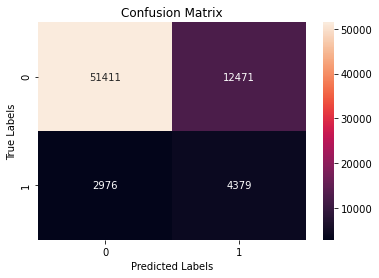

In [66]:
# Prediction
y_pred_svm = svm.predict(X_test)

# Model evaluation
evaluate_model(y_test, y_pred_svm)

AUC score: 0.700078991876827


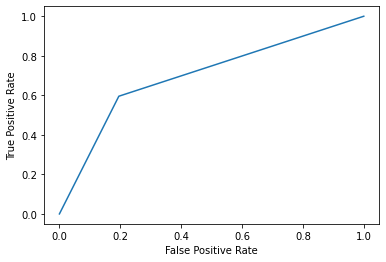

In [67]:
plot_roc_curve(y_test, y_pred_svm)
print(f'AUC score: {met.roc_auc_score(y_test, y_pred_svm)}')

### 4.0 KNN

#### Hyperparameter Tuning

In [68]:
# Define hyperparameter values
n_neighbors = np.arange(2, 20, 1)
weights = ['uniform', 'distance']
p = [1, 2]

# Create a list of all combinations of hyperparameters
hyperparameter_combinations = list(product(n_neighbors, weights, p))

# Total number of combinations
total_combinations = len(hyperparameter_combinations)

best_score = 0
best_params = {}

# Loop through all combinations
for i, (n_neighbors, weights, p) in enumerate(hyperparameter_combinations, 1):
    print(f"Progress: {i}/{total_combinations}")
    print(f"n_neighbors: {n_neighbors}, weights: {weights}, p: {p}")
    
    # Create RandomForestClassifier with current hyperparameters
    knn = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        weights=weights,
        p=p
    )

    # Fit on training data
    knn.fit(X_train, y_train)

    # Predict on validation set
    y_val_pred = knn.predict(X_val)

    # Evaluate accuracy on validation set
    f1 = met.f1_score(y_val, y_val_pred, average='macro')
    print("Current score: ", f1)

    # Check if current model is the best
    if f1 > best_score:
        best_score = f1
        best_params = {
            'n_neighbors': n_neighbors,
            'weights': weights,
            'p': p
        }

    # Add a new line for better readability
    print("\n")

# Display the best parameters found 
print("Best parameters:", best_params)
print("Best score on Validation Set:", best_score)

Progress: 1/72
n_neighbors: 2, weights: uniform, p: 1
Current score:  0.5717843542212386


Progress: 2/72
n_neighbors: 2, weights: uniform, p: 2
Current score:  0.5583378381409491


Progress: 3/72
n_neighbors: 2, weights: distance, p: 1
Current score:  0.5737303569543203


Progress: 4/72
n_neighbors: 2, weights: distance, p: 2
Current score:  0.5601122921531627


Progress: 5/72
n_neighbors: 3, weights: uniform, p: 1
Current score:  0.5724656452173986


Progress: 6/72
n_neighbors: 3, weights: uniform, p: 2
Current score:  0.5544427458946393


Progress: 7/72
n_neighbors: 3, weights: distance, p: 1
Current score:  0.572523443074083


Progress: 8/72
n_neighbors: 3, weights: distance, p: 2
Current score:  0.5544940739206337


Progress: 9/72
n_neighbors: 4, weights: uniform, p: 1
Current score:  0.5782740139609452


Progress: 10/72
n_neighbors: 4, weights: uniform, p: 2
Current score:  0.5570396575611434


Progress: 11/72
n_neighbors: 4, weights: distance, p: 1
Current score:  0.574452671954

#### Model

In [69]:
# Model with best params
knn = KNeighborsClassifier(
    n_neighbors=4,
    weights='uniform',
    p=1
)

# Fit training dataset
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, p=1)

Test Accuracy: 68.7325%

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.71      0.80     63882
           1       0.17      0.52      0.25      7355

    accuracy                           0.69     71237
   macro avg       0.55      0.61      0.53     71237
weighted avg       0.85      0.69      0.75     71237



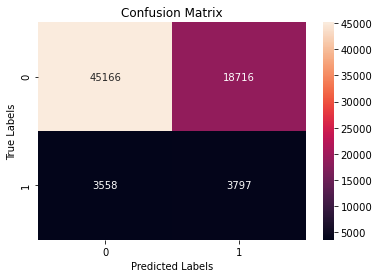

In [70]:
# Prediction
y_pred_knn = knn.predict(X_test)

# Model evaluation
evaluate_model(y_test, y_pred_knn)

AUC score: 0.6116348865603691


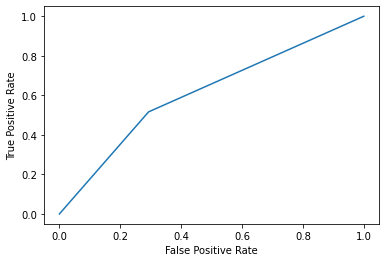

In [71]:
plot_roc_curve(y_test, y_pred_knn)
print(f'AUC score: {met.roc_auc_score(y_test, y_pred_knn)}')

## Statistical Test

In [94]:
# Import libraries for statistical test
from mlxtend.evaluate import cochrans_q
from mlxtend.evaluate import mcnemar_table
from mlxtend.evaluate import mcnemar

# Use result of XGBoost
# Null hypothesis: There is no significant difference in the performance
#                  among the models using different feature sets (MFCC, GTCC, GTCC_MFCC).
# Significance level (alpha-value): 0.01
y_target = np.array(y_test)
y_mfcc = np.array(y_pred_rf_mfcc)
y_gtcc = np.array(y_pred_rf_gtcc)
y_gtcc_mfcc = np.array(y_pred_rf_gtcc_mfcc)

# Conduct Cochran's Q test
q, p_value = cochrans_q(y_target,
                        y_mfcc,
                        y_gtcc,
                        y_gtcc_mfcc)

print('Q: %.3f' % q)
print('p-value: %.3f' % p_value)

Q: 57.500
p-value: 0.000


In [95]:
# McNemar's test for MFCC & GTCC
chi2, p_value = mcnemar(mcnemar_table(y_target,
                                      y_mfcc,
                                      y_gtcc),
                        corrected=False)

print('McNemar\'s Chi^2: %.3f' % chi2)
print('McNemar\'s p-value: %.3f' % p_value)

McNemar's Chi^2: 5.355
McNemar's p-value: 0.021


In [96]:
# McNemar's test for MFCC & GTCC-MFCC
chi2, p_value = mcnemar(mcnemar_table(y_target,
                                      y_mfcc,
                                      y_gtcc_mfcc),
                        corrected=False)

print('McNemar\'s Chi^2: %.3f' % chi2)
print('McNemar\'s p-value: %.3f' % p_value)

McNemar's Chi^2: 21.565
McNemar's p-value: 0.000


In [97]:
# McNemar's test for GTCC & GTCC-MFCC
chi2, p_value = mcnemar(mcnemar_table(y_target,
                                      y_gtcc,
                                      y_gtcc_mfcc),
                        corrected=False)

print('McNemar\'s Chi^2: %.3f' % chi2)
print('McNemar\'s p-value: %.3f' % p_value)

McNemar's Chi^2: 87.375
McNemar's p-value: 0.000
